In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tike
import xdesign as xd

Will use `scipy.optimize.linprog`.


In [2]:
NPIXEL = 16
PIXEL_SIZE = 1/NPIXEL
TOTAL_TIME = 1.0
region = np.array([[-PIXEL_SIZE, PIXEL_SIZE], [-1, 1], [-1, 1]])/2
ideal_mean = TOTAL_TIME * PIXEL_SIZE
S_FREQ = 1/2**11

def circle_density(x, y, radius=PIXEL_SIZE/2):
    """Return True for (x,y) contained by the circle with given radius"""
    return x**2 + y**2 <= radius**2


probe = tike.Probe(density_profile=None,
                   width=PIXEL_SIZE,
                   aspect=1.0)

def get_mask(A):
    """Return a boolean mask for dimensions 1 & 2 of A"""
    assert A.shape[1] == A.shape[2]
    radius = A.shape[1] / 2.0
    coords = np.arange(A.shape[1]) - A.shape[1] / 2.0 + 0.5,
    x, y = np.meshgrid(coords, coords)
    mask = circle_density(x, y, radius=radius)
    return mask


def get_metric(coverage):
    """Return the standard deviation from the ideal coverage from the region
    inside the cylindrical mask
    """
    ideal_mean = TOTAL_TIME * PIXEL_SIZE
    if coverage.ndim > 3:
        coverage = coverage.trace(axis1=3, axis2=4)
    x = coverage[:, get_mask(coverage)].flatten()
    metric = np.sqrt(np.sum((ideal_mean - x)**2) / x.size) - np.mean(x)
    return metric

def fly2D(t, N_rotation=0):
    h = t / TOTAL_TIME - 0.5 #* (1 + PIXEL_SIZE)
    v = 0 * t
    theta = np.pi/3 +  N_rotation * 2 * np.pi * t / TOTAL_TIME
    return theta, h, v

def raster2Dt(t, N_raster=1):
    h = tike.triangle(0.5, N_raster/2, np.pi/2, t)
    v = 0 * t
    theta = np.pi/3 + 2 * np.pi * t / TOTAL_TIME
    return theta, h, v

def raster2Ds(t, N_raster=1):
    h = tike.sinusoid(0.5, N_raster/2, np.pi/2, t)
    v = 0 * t
    theta = np.pi/3 + 2 * np.pi * t / TOTAL_TIME
    return theta, h, v

In [3]:
# fake up the array of the scalar mappable. Urgh…
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=2))
sm._A = []

# 2D coverage as a function of rotation speed

Show a bunch of plots as a function of number of rotations per raster traversal.

In [4]:
# More rotations than raster traversals
num_rotations = 2 ** np.arange(0,6)
coverage_maps = list()
for R in num_rotations:
    kwargs = {'N_rotation' : R}
    tstep_guess = TOTAL_TIME / (NPIXEL * max(1, R))
    coverage = probe.coverage(trajectory=fly2D, region=region,
                              pixel_size=PIXEL_SIZE,
                              tmin=0, tmax=TOTAL_TIME, tstep=tstep_guess,
                              tkwargs=kwargs, anisotropy=True)
    coverage_maps.append(coverage)

INFO:tike.probe: line_width is 0.00390625 cm
INFO:tike.probe: probe uses 256 lines
INFO:tike.probe: procedure is 524,288 lines
INFO:root: coverage 1,024 element grid
INFO:tike.probe: line_width is 0.00390625 cm
INFO:tike.probe: probe uses 256 lines
INFO:tike.probe: procedure is 1,048,576 lines
INFO:root: coverage 1,024 element grid
INFO:tike.probe: line_width is 0.00390625 cm
INFO:tike.probe: probe uses 256 lines
INFO:tike.probe: procedure is 2,097,152 lines
INFO:root: coverage 1,024 element grid
INFO:tike.probe: line_width is 0.00390625 cm
INFO:tike.probe: probe uses 256 lines
INFO:tike.probe: procedure is 4,194,304 lines
INFO:root: coverage 1,024 element grid
INFO:tike.probe: line_width is 0.00390625 cm
INFO:tike.probe: probe uses 256 lines
INFO:tike.probe: procedure is 8,388,608 lines
INFO:root: coverage 1,024 element grid
INFO:tike.probe: line_width is 0.00390625 cm
INFO:tike.probe: probe uses 256 lines
INFO:tike.probe: procedure is 16,777,216 lines
INFO:root: coverage 1,024 elemen

/home/beams/B242827/intel/intelpython3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


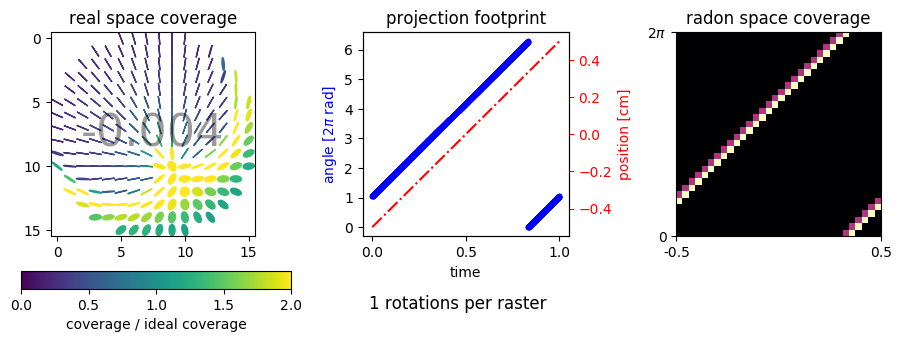

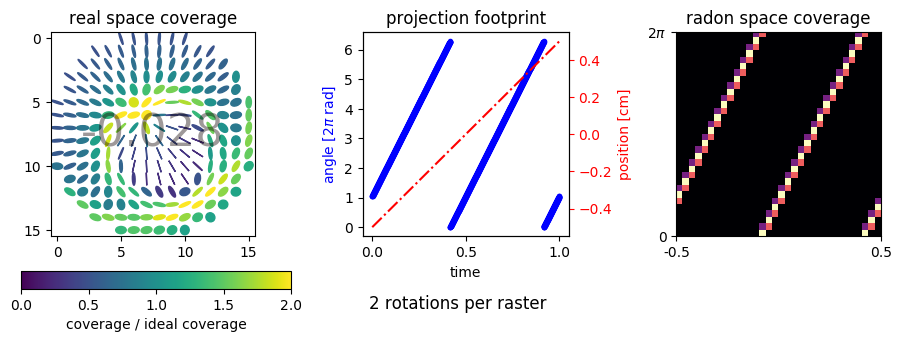

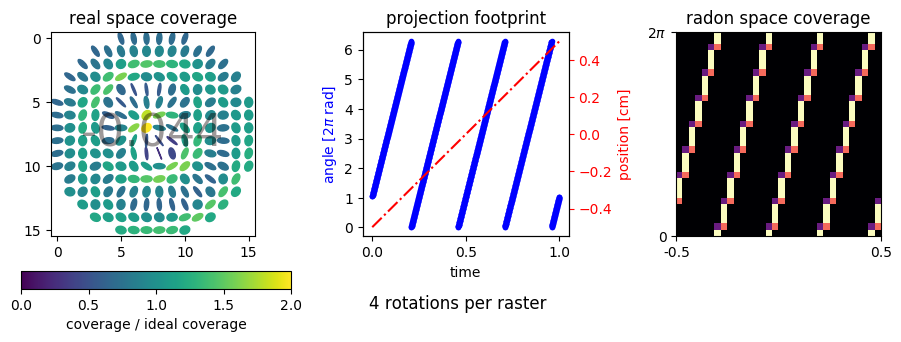

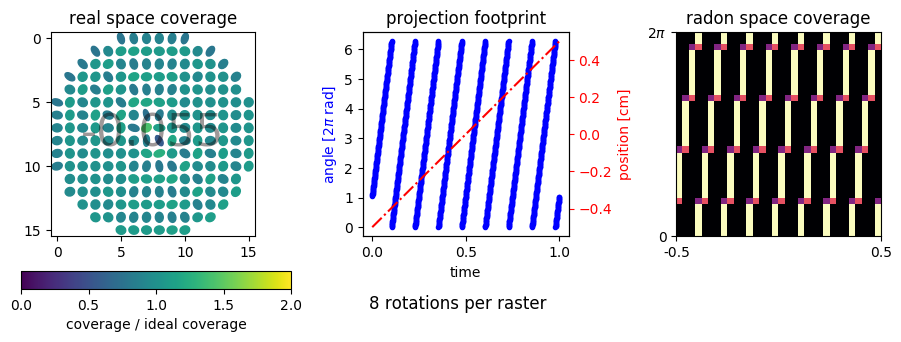

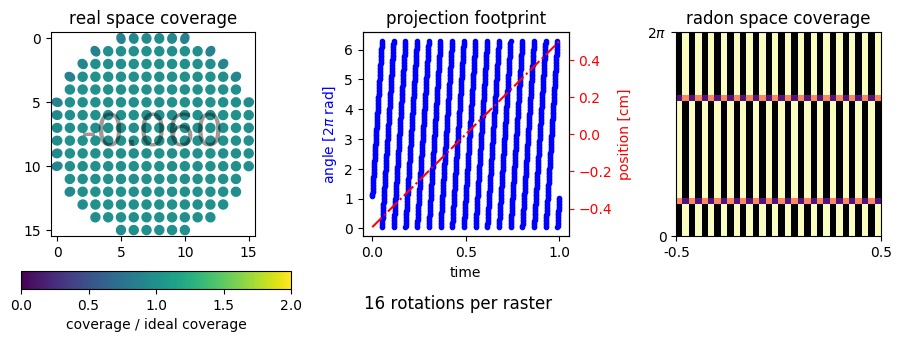

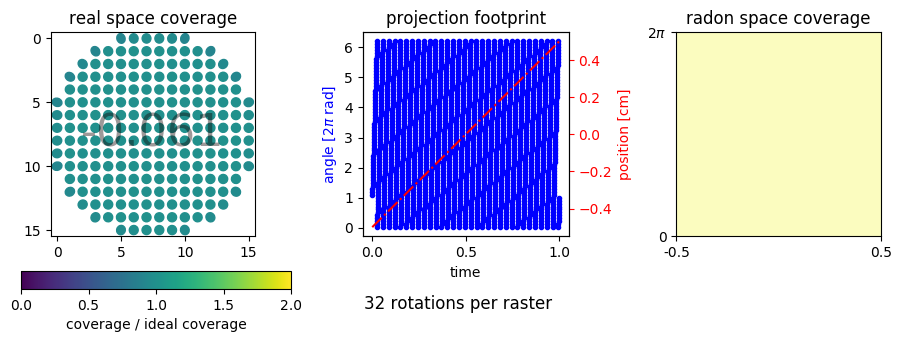

In [5]:
for i in range(len(coverage_maps)):
    fig = plt.figure(figsize=(9,3), dpi=100)
    plt.suptitle("{} rotations per raster".format(num_rotations[i]), y=0.0)

    plt.subplot(1,3,1)
    plt.title('real space coverage')
    mask = get_mask(coverage_maps[i])
    cm = coverage_maps[i][0,...]
    cm[~mask, ...] = np.nan
#     plt.imshow(cm.trace(axis1=2, axis2=3)/ideal_mean, vmin=0, vmax=2)
    xd.plot_coverage_anisotropy(cm, trace_normal=2*ideal_mean)
    m = get_metric(coverage_maps[i])
    plt.xticks([0, 5, 10, 15])
    plt.yticks([0, 5, 10, 15])
    plt.text(7.5, 7.45, "{:03.3f}".format(m), ha='center', va='center',
             size=32, color=(0.05, 0., 0., 0.4))
    
    ax1 = plt.subplot(1,3,(2))
    plt.title('projection footprint')
    plt.xlabel('time')
    plt.ylabel('angle [$2\pi$ rad]', color='b')
    t = np.arange(0,1,S_FREQ) + S_FREQ/2
    th, h, v = fly2D(t, N_rotation=num_rotations[i])
    ax1.plot(t, th%(2*np.pi), 'b.')
    ax2 = ax1.twinx()
    ax2.plot(t, h,'r-.')
    ax2.set_ylabel('position [cm]', color='r')
    ax2.tick_params('y', colors='r')
    
    plt.subplot(1,3,3)
    hist, x, y, none = plt.hist2d(h, th%(2*np.pi), 2*NPIXEL)
    plt.cla()
    plt.imshow((hist*S_FREQ).T, vmin=0, origin='lower', cmap='magma')
    plt.title('radon space coverage')
    plt.xticks([-.5, 2*NPIXEL-.5],[-.5, 0.5])
    plt.yticks([-.5, 2*NPIXEL-.5], [0, '2$\pi$'])
#     plt.colorbar(orientation='horizontal')
    
    cbaxes = fig.add_axes([0.015, 0.02, 0.30, 0.06]) 
    plt.colorbar(sm, cax = cbaxes, orientation='horizontal',
                 ticks=[0, 0.5, 1, 1.5, 2], label='coverage / ideal coverage')
    
    plt.tight_layout()
    plt.show()

In [6]:
# More traversals than rotations
num_rasters = 2 ** np.arange(0,6)
coverage_maps = list()
for R in num_rasters:
    kwargs = {'N_raster' : R}
    tstep_guess = TOTAL_TIME / (NPIXEL * max(1, R))
    coverage = probe.coverage(trajectory=raster2Dt, region=region,
                              pixel_size=PIXEL_SIZE,
                              tmin=0, tmax=TOTAL_TIME, tstep=tstep_guess,
                              tkwargs=kwargs, anisotropy=True)
    coverage_maps.append(coverage)

INFO:tike.probe: line_width is 0.00390625 cm
INFO:tike.probe: probe uses 256 lines
INFO:tike.probe: procedure is 524,288 lines
INFO:root: coverage 1,024 element grid
INFO:tike.probe: line_width is 0.00390625 cm
INFO:tike.probe: probe uses 256 lines
INFO:tike.probe: procedure is 524,288 lines
INFO:root: coverage 1,024 element grid
INFO:tike.probe: line_width is 0.00390625 cm
INFO:tike.probe: probe uses 256 lines
INFO:tike.probe: procedure is 1,048,576 lines
INFO:root: coverage 1,024 element grid
INFO:tike.probe: line_width is 0.00390625 cm
INFO:tike.probe: probe uses 256 lines
INFO:tike.probe: procedure is 1,048,576 lines
INFO:root: coverage 1,024 element grid
INFO:tike.probe: line_width is 0.00390625 cm
INFO:tike.probe: probe uses 256 lines
INFO:tike.probe: procedure is 2,097,152 lines
INFO:root: coverage 1,024 element grid
INFO:tike.probe: line_width is 0.00390625 cm
INFO:tike.probe: probe uses 256 lines
INFO:tike.probe: procedure is 4,194,304 lines
INFO:root: coverage 1,024 element g

/home/beams/B242827/intel/intelpython3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


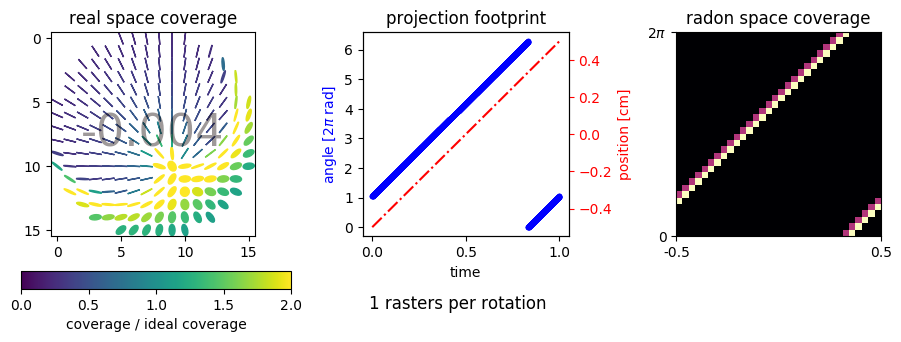

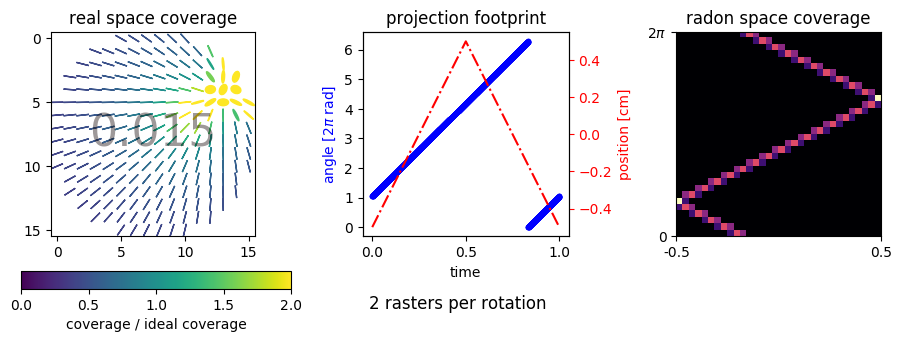

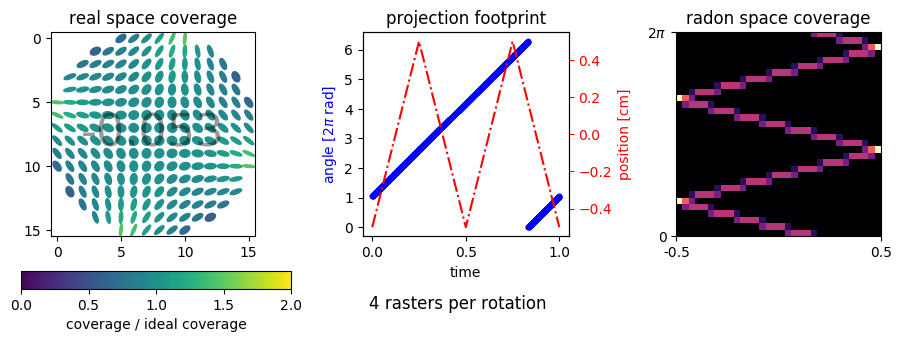

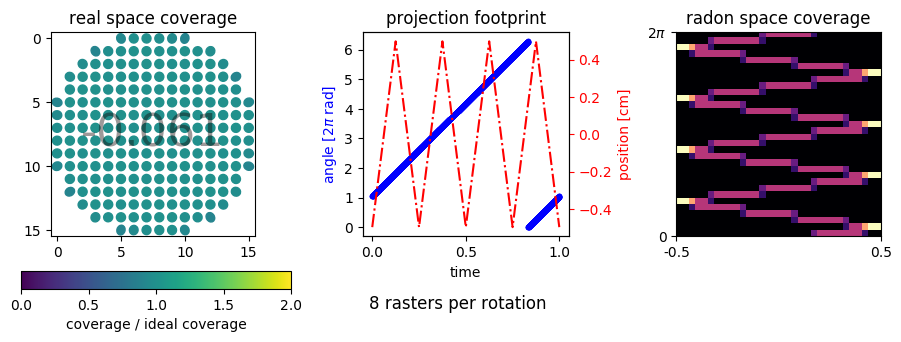

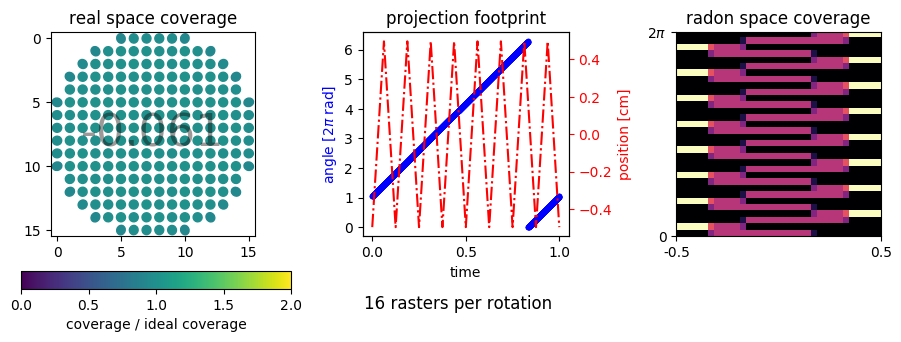

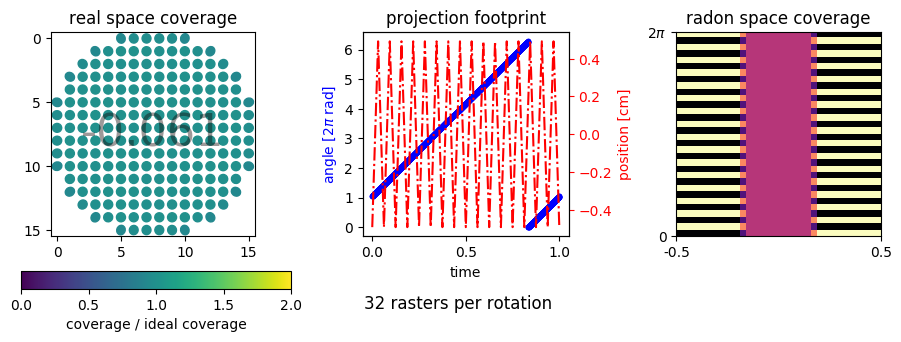

In [7]:
for i in range(len(coverage_maps)):
    fig = plt.figure(figsize=(9,3), dpi=100)
    plt.suptitle("{} rasters per rotation".format(num_rotations[i]), y=0.0)

    plt.subplot(1,3,1)
    plt.title('real space coverage')
    mask = get_mask(coverage_maps[i])
    cm = coverage_maps[i][0,...]
    cm[~mask, ...] = np.nan
#     plt.imshow(cm.trace(axis1=2, axis2=3)/ideal_mean, vmin=0, vmax=2)
    xd.plot_coverage_anisotropy(cm, trace_normal=2*ideal_mean)
    m = get_metric(coverage_maps[i])
    plt.xticks([0, 5, 10, 15])
    plt.yticks([0, 5, 10, 15])
    plt.text(7.5, 7.45, "{:03.3f}".format(m), ha='center', va='center',
             size=32, color=(0.05, 0., 0., 0.4))
    
    ax1 = plt.subplot(1,3,(2))
    plt.title('projection footprint')
    plt.xlabel('time')
    plt.ylabel('angle [$2\pi$ rad]', color='b')
    t = np.arange(0,1,S_FREQ) + S_FREQ/2
    th, h, v = raster2Dt(t, N_raster=num_rasters[i])
    ax1.plot(t, th%(2*np.pi), 'b.')
    ax2 = ax1.twinx()
    ax2.plot(t, h,'r-.')
    ax2.set_ylabel('position [cm]', color='r')
    ax2.tick_params('y', colors='r')
    
    plt.subplot(1,3,3)
    hist, x, y, none = plt.hist2d(h, th%(2*np.pi), 2*NPIXEL)
    plt.cla()
    plt.imshow((hist*S_FREQ).T, vmin=0, origin='lower', cmap='magma')
    plt.title('radon space coverage')
    plt.xticks([-.5, 2*NPIXEL-.5],[-.5, 0.5])
    plt.yticks([-.5, 2*NPIXEL-.5], [0, '2$\pi$'])
#     plt.colorbar(orientation='horizontal')
    
    cbaxes = fig.add_axes([0.015, 0.02, 0.30, 0.06]) 
    plt.colorbar(sm, cax = cbaxes, orientation='horizontal',
                 ticks=[0, 0.5, 1, 1.5, 2], label='coverage / ideal coverage')
    
    plt.tight_layout()
    plt.show()

In [8]:
# More traversals than rotations
num_rasters = 2 ** np.arange(0,6)
coverage_maps = list()
for R in num_rasters:
    kwargs = {'N_raster' : R}
    tstep_guess = TOTAL_TIME / (NPIXEL * max(1, R))
    coverage = probe.coverage(trajectory=raster2Ds, region=region,
                              pixel_size=PIXEL_SIZE,
                              tmin=0, tmax=TOTAL_TIME, tstep=tstep_guess,
                              tkwargs=kwargs, anisotropy=True)
    coverage_maps.append(coverage)

INFO:tike.probe: line_width is 0.00390625 cm
INFO:tike.probe: probe uses 256 lines
INFO:tike.probe: procedure is 524,288 lines
INFO:root: coverage 1,024 element grid
INFO:tike.probe: line_width is 0.00390625 cm
INFO:tike.probe: probe uses 256 lines
INFO:tike.probe: procedure is 524,288 lines
INFO:root: coverage 1,024 element grid
INFO:tike.probe: line_width is 0.00390625 cm
INFO:tike.probe: probe uses 256 lines
INFO:tike.probe: procedure is 864,256 lines
INFO:root: coverage 1,024 element grid
INFO:tike.probe: line_width is 0.00390625 cm
INFO:tike.probe: probe uses 256 lines
INFO:tike.probe: procedure is 1,261,568 lines
INFO:root: coverage 1,024 element grid
INFO:tike.probe: line_width is 0.00390625 cm
INFO:tike.probe: probe uses 256 lines
INFO:tike.probe: procedure is 1,744,896 lines
INFO:root: coverage 1,024 element grid
INFO:tike.probe: line_width is 0.00390625 cm
INFO:tike.probe: probe uses 256 lines
INFO:tike.probe: procedure is 3,260,416 lines
INFO:root: coverage 1,024 element gri

/home/beams/B242827/intel/intelpython3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


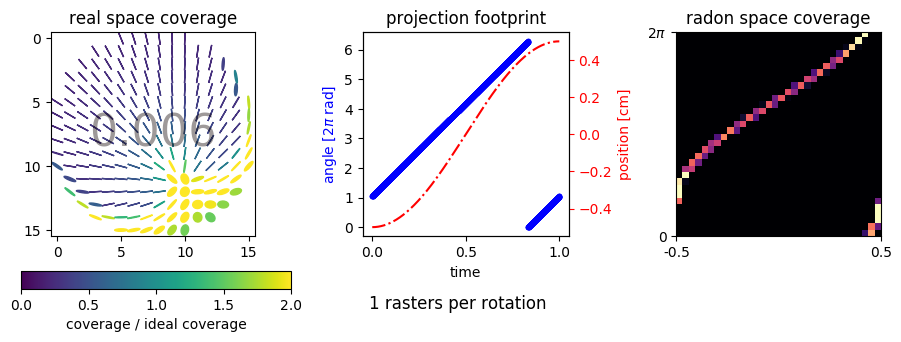

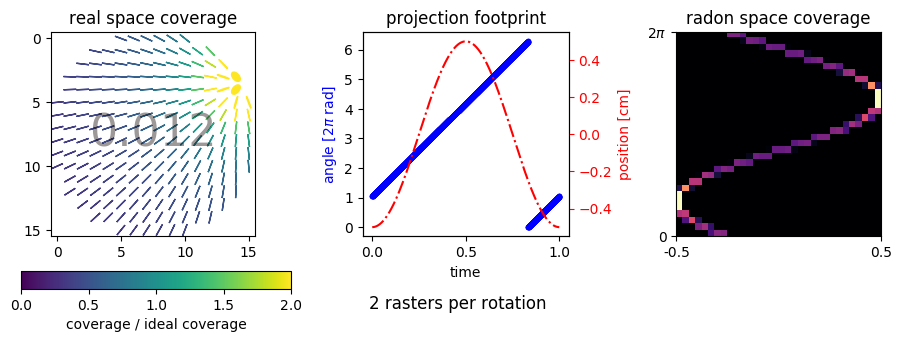

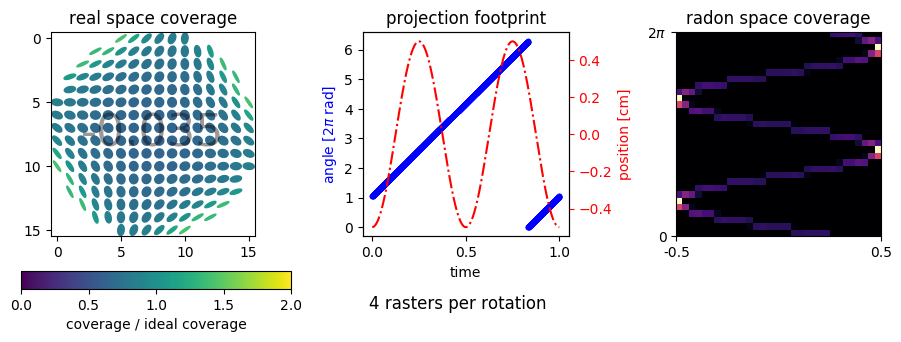

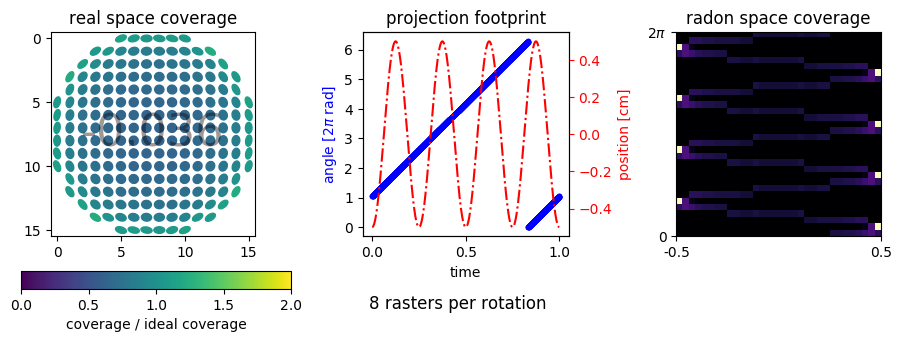

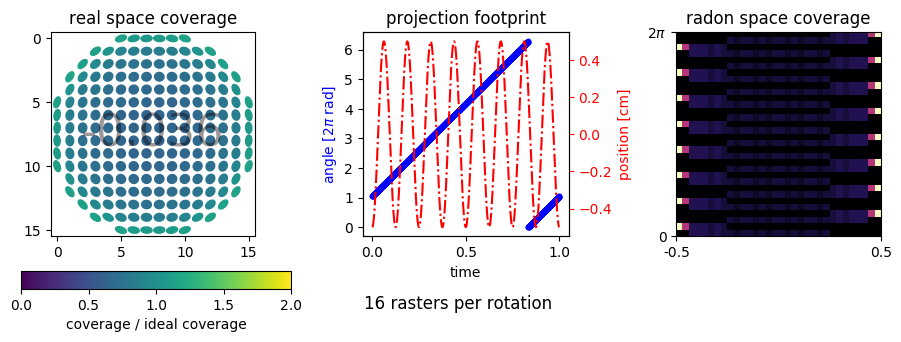

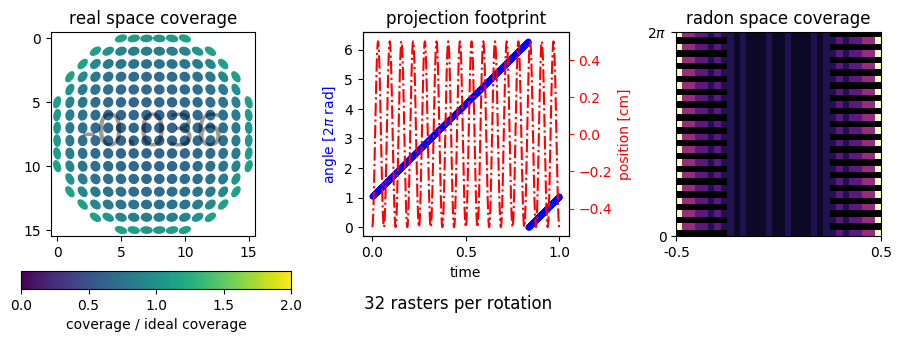

In [9]:
for i in range(len(coverage_maps)):
    fig = plt.figure(figsize=(9,3), dpi=100)
    plt.suptitle("{} rasters per rotation".format(num_rotations[i]), y=0.0)

    plt.subplot(1,3,1)
    plt.title('real space coverage')
    mask = get_mask(coverage_maps[i])
    cm = coverage_maps[i][0,...]
    cm[~mask, ...] = np.nan
#     plt.imshow(cm.trace(axis1=2, axis2=3)/ideal_mean, vmin=0, vmax=2)
    xd.plot_coverage_anisotropy(cm, trace_normal=2*ideal_mean)
    m = get_metric(coverage_maps[i])
    plt.xticks([0, 5, 10, 15])
    plt.yticks([0, 5, 10, 15])
    plt.text(7.5, 7.45, "{:03.3f}".format(m), ha='center', va='center',
             size=32, color=(0.05, 0., 0., 0.4))
    
    ax1 = plt.subplot(1,3,(2))
    plt.title('projection footprint')
    plt.xlabel('time')
    plt.ylabel('angle [$2\pi$ rad]', color='b')
    t = np.arange(0,1,S_FREQ) + S_FREQ/2
    th, h, v = raster2Ds(t, N_raster=num_rasters[i])
    ax1.plot(t, th%(2*np.pi), 'b.')
    ax2 = ax1.twinx()
    ax2.plot(t, h,'r-.')
    ax2.set_ylabel('position [cm]', color='r')
    ax2.tick_params('y', colors='r')
    
    plt.subplot(1,3,3)
    hist, x, y, none = plt.hist2d(h, th%(2*np.pi), 2*NPIXEL)
    plt.cla()
    plt.imshow((hist*S_FREQ).T, vmin=0, origin='lower', cmap='magma')
    plt.title('radon space coverage')
    plt.xticks([-.5, 2*NPIXEL-.5],[-.5, 0.5])
    plt.yticks([-.5, 2*NPIXEL-.5], [0, '2$\pi$'])
#     plt.colorbar(orientation='horizontal')
    
    cbaxes = fig.add_axes([0.015, 0.02, 0.30, 0.06]) 
    plt.colorbar(sm, cax = cbaxes, orientation='horizontal',
                 ticks=[0, 0.5, 1, 1.5, 2], label='coverage / ideal coverage')
    
    plt.tight_layout()
    plt.show()